In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from collections import namedtuple, deque

from IPython.display import Image 


Player,Game and GameState Classes

In [2]:
class Player:

    def __init__(self, name, hands, game_state, stack_size=1):

        self.game_state = game_state
        self.hand = None
        self.hands = hands
        self.name = name
        self.stack_size = stack_size

    def action(self):

        if self.name == 'SB':

            return np.random.choice([0, 1])

        elif self.name == 'BB':

            sb_action = np.where(self.game_state.game_state[0] == 1.0)[0]
            print(str(self.game_state.game_state))
            print(str(sb_action))
            if sb_action == 0:
                return 2  # force call

            elif sb_action == 1:
                return 1  # force check

            else:
                print("sb took illegal action")

    def get_hand_repr(self):

        hand_repr = np.zeros(3)

        hand_repr[np.where(self.hands == self.hand)[0][0]] = 1

        return hand_repr

    def get_state(self):
        '''
            Get the current game state and and pre append
            the players holding
        '''
        hand_repr = self.get_hand_repr()
        return np.concatenate((hand_repr, self.game_state))

# Defining a Game simulation and getting rid of our Tree structures
class Game:

    def __init__(self):

        self.actions = ['bet', 'check', 'call', 'fold']
        self.GameState = None  # tensor that tracks current state
        self.current_player = None
        self.current_pot = 1.0  # starting amount = 1
        self.hands = [0, 1, 2]
        self.hand_string = ['A', 'K', 'Q']
        self.SB = None
        self.BB = None
        self.terminal_state = False
        self.init_game()

    def deal(self):
        return np.random.choice(self.hands, 2, replace=False)

    def get_next_state(self, a):
        '''
        The Game should be able to receive an action
        from one of the players and be able to update the current
        game state
        For the simple AKQ the only information the game needs is
        (player,action)
        In a more complex environment like LHE the game needs to be
        able to know more information
        (player, round, num_raises,action) + (board repr)

        '''

        print("Get next state")
        print("CUrrent state: ")
        print(str(self.GameState.game_state))
        if self.GameState.current_player.name == 'SB':

            self.GameState.game_state[0][a] = 1

            if self.actions[a] == 'bet':

                self.GameState.current_pot += 1.0
                self.SB.stack_size -= 1.0


            self.GameState.current_player.name = 'BB'

        elif self.GameState.current_player.name == 'BB':

            self.GameState.game_state[1][a] = 1

            if self.actions[a] == 'call':

                self.GameState.current_pot += 1.0
                self.BB.stack_size -= 1.0


            self.GameState.current_player.name = 'SB'

            self.terminal_state = True

        print("Updated state: ")
        print(str(self.GameState.game_state))

    def get_winning_player(self):

        if self.SB.hand < self.BB.hand:

            return self.SB
        else:
            return self.BB

    def init_game(self):

        game_state_init = np.zeros((2, 4))

        self.GameState = GameState(game_state_init,current_player=None,pot=1.0)

        SB = Player(name="SB", hands=self.hands, game_state=self.GameState)

        BB = Player(name="BB", hands=self.hands, game_state=self.GameState)

        self.SB = SB
        self.BB = BB

    def reward(self):

        '''
            For the AKQ simple game this is... well simple but in general
            we will need to do an evaluation based off of how the episode
            was terminated.
        '''

        # get last 'node' in game state where action > 0

        i, j = np.where(self.GameState.game_state == 1)

        terminal_action_index = j[-1]

        terminal_row_index = i[-1]

        terminal_action = self.actions[terminal_action_index]

        winning_player = self.get_winning_player()

        print()

        reward = {
            'SB': 0.0,
            'BB': 0.0
        }

        print("SB hand: {}".format(self.hand_string[self.SB.hand]))

        print("BB hand: {}".format(self.hand_string[self.BB.hand]))

        if winning_player.name == 'SB':

            reward['SB'] = self.GameState.current_pot + self.SB.stack_size
            reward['BB'] = self.BB.stack_size
        else:
            reward['BB'] = self.GameState.current_pot + self.BB.stack_size
            reward['SB'] = self.SB.stack_size

        return reward

    def run_sim(self):

        hand1, hand2 = self.deal()

        self.SB.hand = hand1
        self.BB.hand = hand2

        # init game state
        # game_state = {player,action,terminal}
        # action = [0,0
        # example
        # actions = [bet,check,call,fold]
        # SB check BB check
        # [1,0],[0,1,0,0],[0,1],[0,1,0,0] # Wrong

        game_state_init = np.zeros((2, 4))

        self.GameState.current_pot = 1.0

        self.GameState.game_state = game_state_init

        self.GameState.current_player = self.SB

        r = self.simulate()

        print("End of game")
        print("Reward: " + str(r))
        print(str(self.GameState.game_state))

    def simulate(self):

        s = self.GameState.game_state

        if self.terminal_state == True:

            return self.reward()

        action = self.GameState.current_player.action()

        next_state = self.get_next_state(action)

        r = self.simulate()

        return r

class GameState:
    '''
    Allow us to be able to pass state between classes
    '''
    def __init__(self,game_state,current_player,pot):


        self.game_state = game_state  # tensor that tracks current state
        self.current_player = current_player
        self.pot = pot # starting amount = 1


QNetwork, PolicyNetwork

In [15]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size,seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.action_size = action_size
        self.model = None
        self.seed = torch.manual_seed(seed)
        self.state_size = state_size
        self.init()


    def init(self):

        model = nn.Sequential(OrderedDict([
            ('ds1',nn.Linear(self.state_size,64)),
            ('act1', nn.Sigmoid()),
            ('ds2', nn.Linear(64, 32)),
            ('act2', nn.Sigmoid()),
            ('ds3', nn.Linear(32, self.action_size))

        ]))

        self.model = model


    def forward(self, state):

        return self.model(state)

class PolicyNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size,seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(PolicyNetwork, self).__init__()
        self.action_size = action_size
        self.model = None
        self.seed = torch.manual_seed(seed)
        self.state_size = state_size
        self.init()


    def init(self):

        model = nn.Sequential(OrderedDict([
            ('ds1',nn.Linear(self.state_size,64)),
            ('act1', nn.Sigmoid()),
            ('ds2', nn.Linear(64, 32)),
            ('act2', nn.Sigmoid()),
            ('ds3', nn.Linear(32, self.action_size))

        ]))

        self.model = model


    def forward(self, state):

        return self.model(state)


Q agent

In [ ]:
# coding=utf-8

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64  # minibatch size
GAMMA = 0.99  # discount factor
TAU = 1e-3  # for soft update of target parameters
LR = 5e-4  # learning rate
UPDATE_EVERY = 4  # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class QAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        
        # Policy network
        self.policynetwork = 

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        '''
        for i in range(len(states)):

            state, action, reward ,next_state, done = states[i] , actions[i] , rewards[i], next_states[i], dones[i]

            y_i = reward

            if not done:

                y_i = reward + GAMMA*self.qnetwork_target(next_state).detach().max()

            q_predict = self.qnetwork_local(state)[action]

            loss = F.mse_loss(y_i,q_predict)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        '''
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(
            device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(
            device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

Policy Agent

In [ ]:
class PolicyAgent:
    def __init__():
        pass
    
    

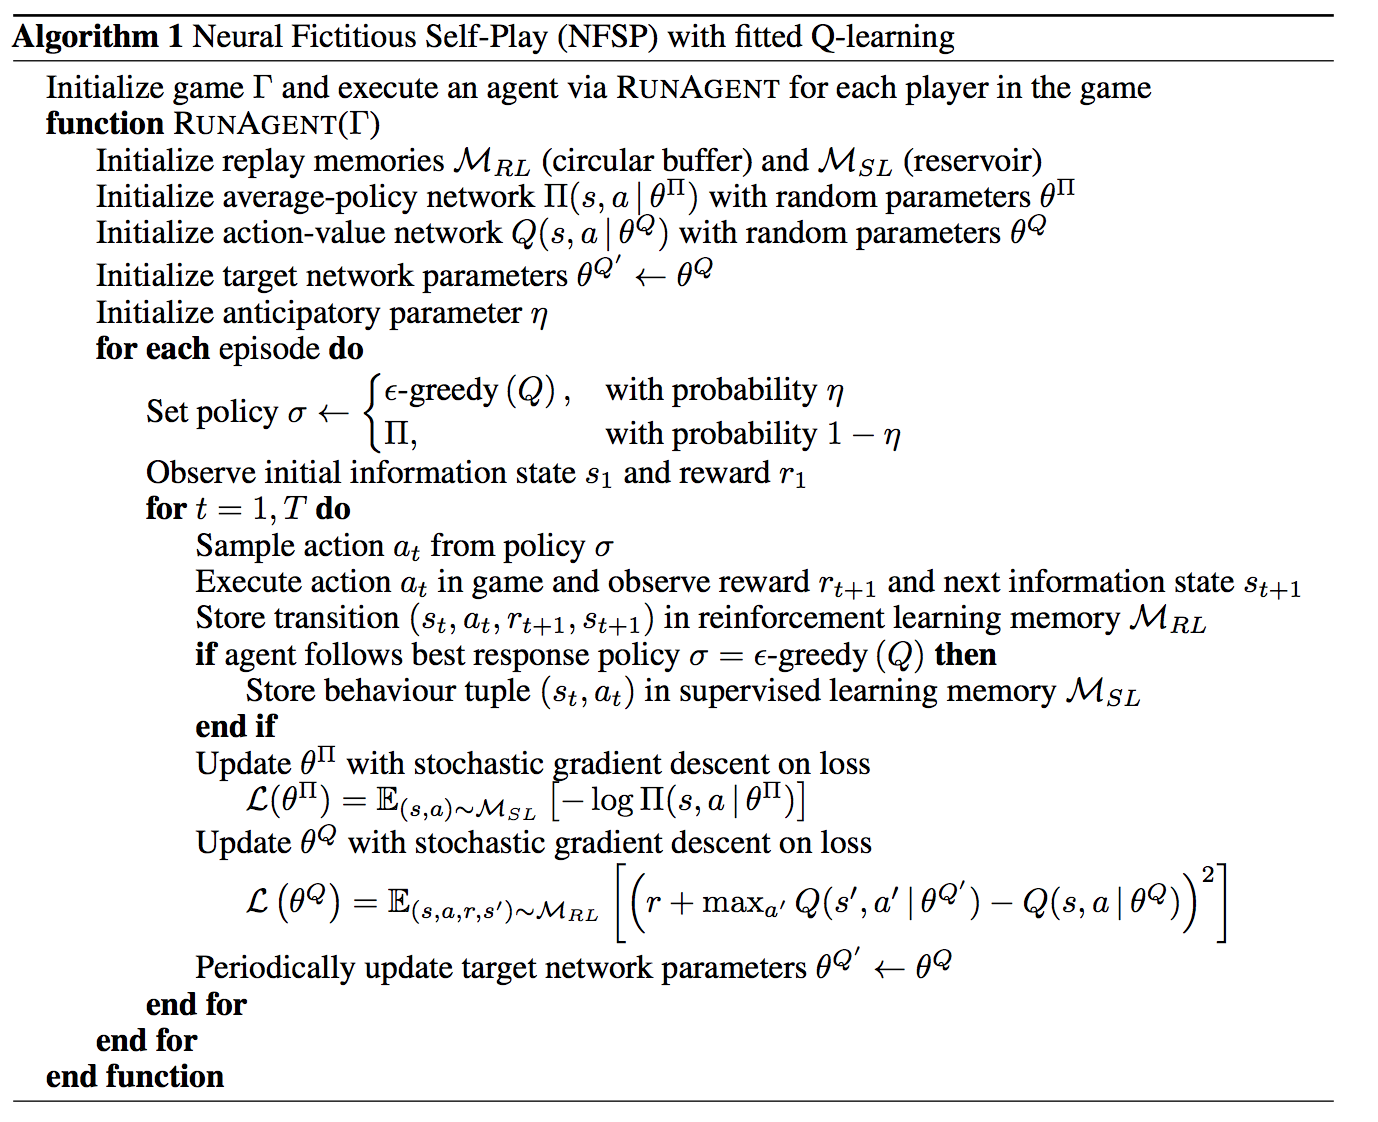

In [11]:
Image(filename='/Users/befeltingu/Desktop/nfsp_algo.png',width=600,height=600)

In [16]:
def run_nfsp():
    '''
    Run neural fictious self - play as described in the paper by Johannes Heinrich and David Silver
    https://arxiv.org/pdf/1603.01121.pdf
    
    '''
    
    replay_mem =

SyntaxError: invalid syntax (<ipython-input-16-960f257ccee4>, line 8)

In [17]:
import random

In [ ]:
random.sample?